In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Activation, Flatten, \
Conv3D,MaxPooling3D,Input,GlobalAveragePooling3D, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,X_test,y_test,type_cm,display_labels,cmap=plt.cm.Blues,normalize=True):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    c_mat = confusion_matrix(y_test,y_pred)
    if normalize:
        c_mat = np.round(c_mat.astype('float') / c_mat.sum(axis=1)[:, np.newaxis],4)
    plt.imshow(c_mat, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix'+type_cm)
    plt.colorbar()
    tick_marks = np.arange(len(display_labels))
    plt.xticks(tick_marks, display_labels, rotation=0)
    plt.yticks(tick_marks, display_labels)
    thresh = c_mat.max() / 2.
    for i, j in itertools.product(range(c_mat.shape[0]), range(c_mat.shape[1])):
        plt.text(j, i, c_mat[i, j],
                 horizontalalignment="center",
                 color="white" if c_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def disp_confusion_matrix(model,X,y,type_cm,class_label):
    disp = plot_confusion_matrix(model, X, y, type_cm,display_labels=class_label,
                                 cmap=plt.cm.Blues)
    
def testers(lr,channels,model,epochs=100,verb=1):
#     model = get_model(width=42,height=300,depth=6,activation='relu',dense_activation=dense_act,
#                   dropout_rate=0.3)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    num_epochs = epochs
    X_test_res = X_test[:,:,:,channels]
    history = model.fit(X_train[:,:,:,channels],y_train[:], epochs = num_epochs,\
                        shuffle=True, verbose=verb,validation_data=(X_test_res,y_test[:]))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Costo vs Época')
    #plt.xlim(0,50)
    plt.ylabel('Costo')
    plt.xlabel('Época')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    disp_confusion_matrix(model,X_test_res,y_test[:],' first six set A',class_label=['Left Hand','Right Hand','Neutral']) 

In [2]:
# X_train = np.load('CWT-D/X_train_s.npy')
# X_test = np.load('CWT-D/X_test_s.npy')
# y_train = np.load('CWT-D/y_train_s.npy')
# y_test = np.load('CWT-D/y_test_s.npy')
path ='Pre-Dat/Fp1-F3-P4-O2-A1-T3'
extension = ''
X_train = np.load(path+'/X_train'+f'{extension}.npy')
X_test = np.load(path+'/X_test'+f'{extension}.npy')
y_train = np.load(path+'/y_train'+f'{extension}.npy')
y_test = np.load(path+'/y_test'+f'{extension}.npy')

In [3]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (3616, 90, 200, 6, 1)
y train shape: (3616, 3)
X test shape: (896, 90, 200, 6, 1)
y test shape: (896, 3)


In [3]:
def get_model(width=38, height=300, depth=6,activation='sigmoid',dense_activation='sigmoid',dropout_rate=0.0,NORM=True):
    """Build a 3D convolutional neural network model."""
    model = Sequential()
    
    model.add(Input((width, height, depth, 1)))

    model.add(Conv3D(filters=128, kernel_size=7,padding='same',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,1)))
    if NORM:
        model.add(BatchNormalization())

    model.add(Conv3D(filters=128, kernel_size=3,padding='valid',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,1)))
    if NORM:
        model.add(BatchNormalization())

    model.add(Conv3D(filters=256, kernel_size=3,padding='same',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,1)))
    if NORM:
        model.add(BatchNormalization())

    model.add(Conv3D(filters=512, kernel_size=3,padding='same',activation=activation))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    if NORM:
        model.add(BatchNormalization())
    
#     model.add(Conv3D(filters=256, kernel_size=3,padding='same',activation=activation))
#     model.add(MaxPooling3D(pool_size=(1,2,1)))
#     if NORM:
#         model.add(BatchNormalization())
    
#     model.add(Conv3D(filters=128, kernel_size=3,padding='same',activation=activation))
#     model.add(MaxPooling3D(pool_size=(2,2,2)))
#     if NORM:
#         model.add(BatchNormalization())

#     model.add(GlobalAveragePooling3D())
    units_in = 512
    model.add(Flatten())
    model.add(Dense(units=units_in, activation=dense_activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=int(units_in/2), activation=dense_activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=int(units_in/4), activation=dense_activation))
    model.add(Dropout(dropout_rate))

#     model.add(Dense(units=int(units_in/8), activation=dense_activation))
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=int(units_in/16), activation='tanh'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=3,kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    model.add(Activation('softmax',name='CNN_EEGModel'))
    return model

In [4]:
def architecture(input_shape, num_classes, activation, dropout=True, batch_normalization=True):
    vpm=300
    model = Sequential()
    
    model.add(Conv2D(32, 7, padding='same', input_shape=input_shape))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())

    model.add(Conv2D(32, 3, padding='valid', input_shape=input_shape))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    model.add(Conv2D(32, 3, padding='same', input_shape=(3,0.5*(vpm-2),1)))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization())
        
    model.add(Conv2D(32, 3, padding='valid', input_shape=(3,0.5*(vpm-2),1)))
    #model.add(Activation(activation))    
    if batch_normalization: 
        model.add(BatchNormalization()) 
        
    model.add(Flatten())
    if dropout:
        model.add(Dropout(0.30))
    
    model.add(Dense(50, kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))    
    if batch_normalization:
        model.add(BatchNormalization())  
    if dropout:
        model.add(Dropout(0.30))
        
    model.add(Dense(50, kernel_initializer='he_uniform',bias_initializer='zeros'))
    model.add(Activation('relu'))    
    if batch_normalization:
        model.add(BatchNormalization())  
    if dropout:
        model.add(Dropout(0.30))
        
    model.add(Dense(num_classes,kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Activation(activation,name='CNN_EEGModel'))
    
    return model

In [5]:
model = get_model(width=90,height=200,depth=6,activation='relu',dense_activation='sigmoid',dropout_rate=0.2)
# model = architecture(input_shape=(42,300,1),activation='sigmoid',num_classes=3,dropout=True,batch_normalization=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 90, 200, 6, 128)   44032     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 45, 100, 6, 128)  0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 45, 100, 6, 128)  512       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 43, 98, 4, 128)    442496    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 21, 49, 4, 128)   0         
 3D)                                                             
                                                        

In [6]:
channel_combs = {
    '1': [1,2,3,4,5,6], '2':[1,3,5,7,9,11],'3':[2,4,6,8,10,12], 
    '4':[7,8,9,10,11,12],'5':[11,13,15,17,19,20], '6':[10,12,14,16,18,20],
    '7':[4,7,9,14,15,20],'8':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],'9':[2,6,8,5,7,11]
    }

In [7]:
testers(1e-3,range(6),epochs=50,model=model)

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/max_pooling3d/MaxPool3D' defined at (most recent call last):
    File "C:\Users\Andrew S\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Andrew S\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Andrew S\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\Andrew S\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\Andrew S\anaconda3\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Andrew S\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Andrew S\AppData\Local\Temp\ipykernel_20636\2819279405.py", line 1, in <cell line: 1>
      testers(1e-3,range(6),epochs=50,model=model)
    File "C:\Users\Andrew S\AppData\Local\Temp\ipykernel_20636\134514209.py", line 46, in testers
      history = model.fit(X_train[:,:,:,channels],y_train[:], epochs = num_epochs,\
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Andrew S\AppData\Roaming\Python\Python38\site-packages\keras\layers\pooling.py", line 699, in call
      outputs = self.pool_function(
Node: 'sequential/max_pooling3d/MaxPool3D'
OOM when allocating tensor with shape[32,45,100,6,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/max_pooling3d/MaxPool3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1940]

Channel 6
Epoch 1/50
68/68 [==============================] - 5s 22ms/step - loss: 1.5974 - accuracy: 0.3676 - val_loss: 1.1792 - val_accuracy: 0.3431
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.3885 - accuracy: 0.3722 - val_loss: 1.1671 - val_accuracy: 0.3431
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.3483 - accuracy: 0.3529 - val_loss: 1.2064 - val_accuracy: 0.3339
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.2493 - accuracy: 0.3709 - val_loss: 1.1618 - val_accuracy: 0.3358
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.2423 - accuracy: 0.3497 - val_loss: 1.1535 - val_accuracy: 0.3541
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.1969 - accuracy: 0.3681 - val_loss: 1.1298 - val_accuracy: 0.3780
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.1671 - accuracy: 0.3791 - val_loss: 1.1273 - val_accuracy: 0.3688
Epo

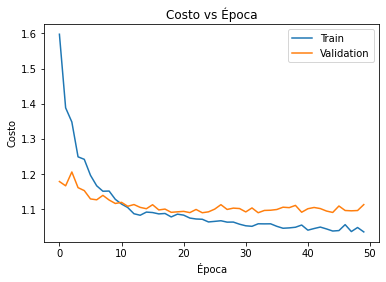

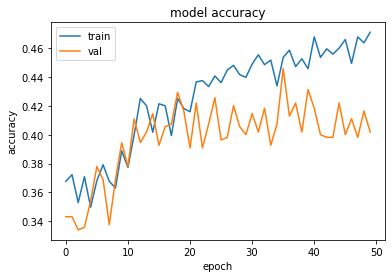

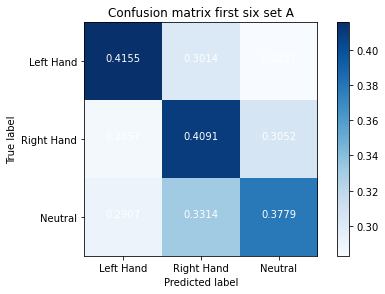

Channel 7
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.1147 - accuracy: 0.3539 - val_loss: 1.0818 - val_accuracy: 0.4202
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0855 - accuracy: 0.3920 - val_loss: 1.0833 - val_accuracy: 0.3982
Epoch 3/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0846 - accuracy: 0.3957 - val_loss: 1.0799 - val_accuracy: 0.4092
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0752 - accuracy: 0.4108 - val_loss: 1.0793 - val_accuracy: 0.4312
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0752 - accuracy: 0.4154 - val_loss: 1.0894 - val_accuracy: 0.3927
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0735 - accuracy: 0.4150 - val_loss: 1.0853 - val_accuracy: 0.4183
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0696 - accuracy: 0.4173 - val_loss: 1.0790 - val_accuracy: 0.4147
Epo

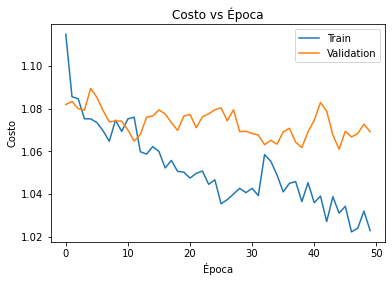

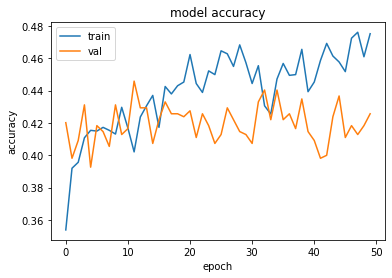

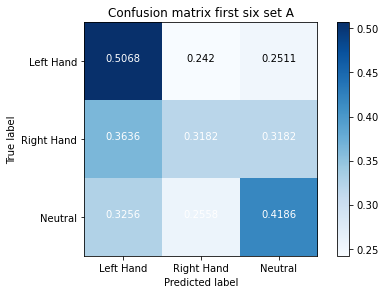

Channel 8
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.1070 - accuracy: 0.3764 - val_loss: 1.0893 - val_accuracy: 0.3670
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0881 - accuracy: 0.3856 - val_loss: 1.0906 - val_accuracy: 0.3596
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0802 - accuracy: 0.3938 - val_loss: 1.0948 - val_accuracy: 0.3578
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0812 - accuracy: 0.3851 - val_loss: 1.0835 - val_accuracy: 0.3872
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0708 - accuracy: 0.4044 - val_loss: 1.0794 - val_accuracy: 0.3963
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0741 - accuracy: 0.4053 - val_loss: 1.0829 - val_accuracy: 0.3798
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0692 - accuracy: 0.4081 - val_loss: 1.1002 - val_accuracy: 0.3450
Epo

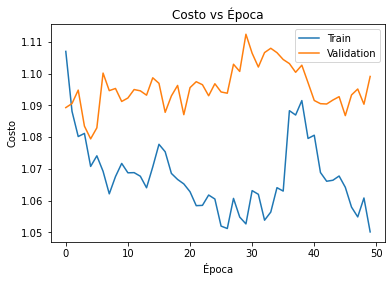

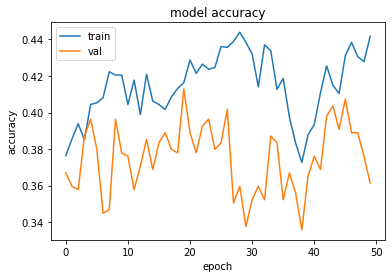

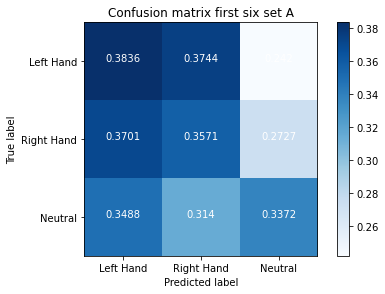

Channel 9
Epoch 1/50
68/68 [==============================] - 2s 21ms/step - loss: 1.0759 - accuracy: 0.4173 - val_loss: 1.0743 - val_accuracy: 0.4183
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0667 - accuracy: 0.4053 - val_loss: 1.0784 - val_accuracy: 0.4147
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0697 - accuracy: 0.4164 - val_loss: 1.0834 - val_accuracy: 0.4220
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0686 - accuracy: 0.4210 - val_loss: 1.0837 - val_accuracy: 0.3945
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0537 - accuracy: 0.4283 - val_loss: 1.0800 - val_accuracy: 0.4073
Epoch 6/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0554 - accuracy: 0.4426 - val_loss: 1.0747 - val_accuracy: 0.4073
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0660 - accuracy: 0.4154 - val_loss: 1.0781 - val_accuracy: 0.3945
Epo

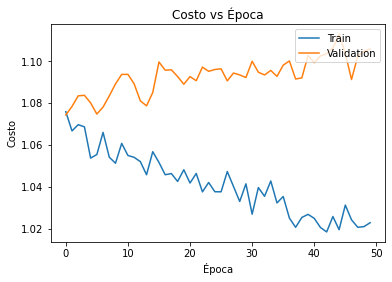

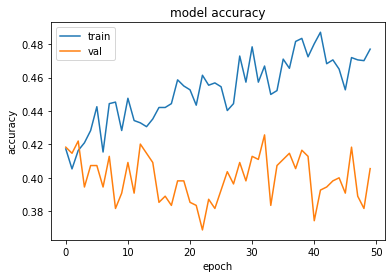

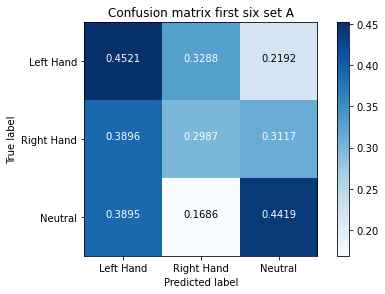

Channel 10
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.1167 - accuracy: 0.3612 - val_loss: 1.0885 - val_accuracy: 0.3835
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0919 - accuracy: 0.3791 - val_loss: 1.0901 - val_accuracy: 0.3688
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0852 - accuracy: 0.3897 - val_loss: 1.0832 - val_accuracy: 0.4055
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0825 - accuracy: 0.3971 - val_loss: 1.0812 - val_accuracy: 0.3908
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0795 - accuracy: 0.3989 - val_loss: 1.0778 - val_accuracy: 0.4055
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0819 - accuracy: 0.4099 - val_loss: 1.0840 - val_accuracy: 0.3817
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0775 - accuracy: 0.4085 - val_loss: 1.0840 - val_accuracy: 0.3688
Ep

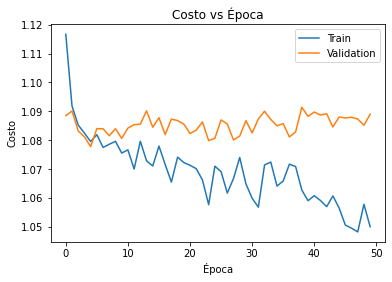

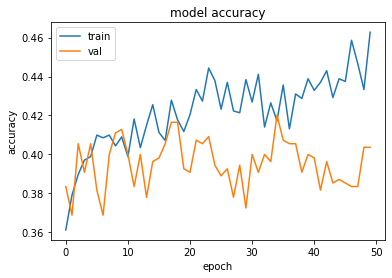

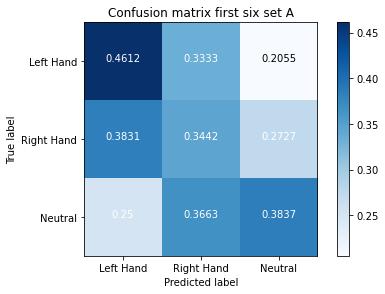

Channel 11
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.1026 - accuracy: 0.3727 - val_loss: 1.0976 - val_accuracy: 0.3725
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0885 - accuracy: 0.3741 - val_loss: 1.0931 - val_accuracy: 0.3908
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0862 - accuracy: 0.3860 - val_loss: 1.0904 - val_accuracy: 0.3743
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0824 - accuracy: 0.4021 - val_loss: 1.0877 - val_accuracy: 0.3835
Epoch 5/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0825 - accuracy: 0.3934 - val_loss: 1.0880 - val_accuracy: 0.3651
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0798 - accuracy: 0.4035 - val_loss: 1.0831 - val_accuracy: 0.3651
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0751 - accuracy: 0.4122 - val_loss: 1.0865 - val_accuracy: 0.3651
Ep

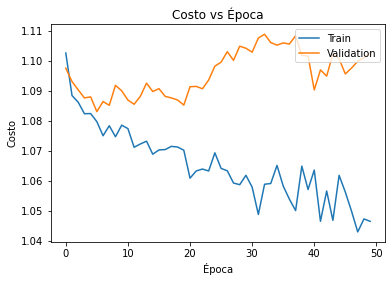

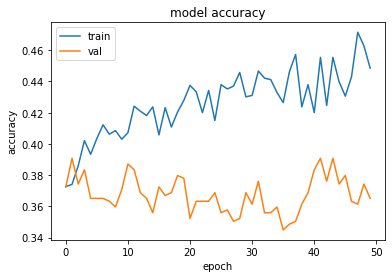

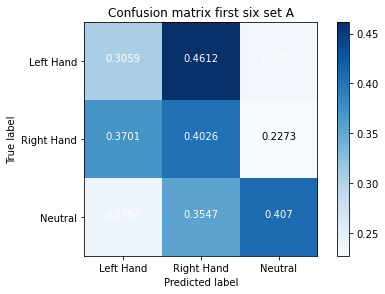

Channel 12
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.1022 - accuracy: 0.3810 - val_loss: 1.1057 - val_accuracy: 0.3174
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0950 - accuracy: 0.3865 - val_loss: 1.0995 - val_accuracy: 0.3523
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0927 - accuracy: 0.3819 - val_loss: 1.0949 - val_accuracy: 0.3670
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0921 - accuracy: 0.3745 - val_loss: 1.0906 - val_accuracy: 0.3908
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0895 - accuracy: 0.3718 - val_loss: 1.0935 - val_accuracy: 0.3578
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0838 - accuracy: 0.3906 - val_loss: 1.0968 - val_accuracy: 0.3450
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0833 - accuracy: 0.3966 - val_loss: 1.0936 - val_accuracy: 0.3523
Ep

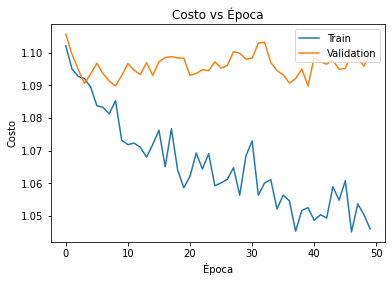

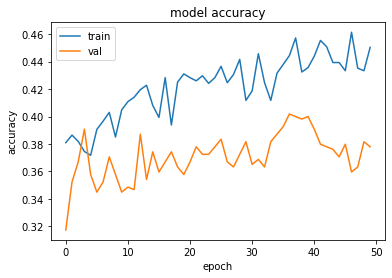

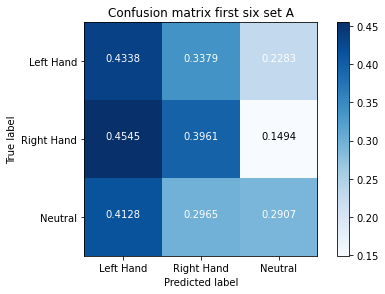

Channel 13
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.1203 - accuracy: 0.3520 - val_loss: 1.0990 - val_accuracy: 0.3523
Epoch 2/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0918 - accuracy: 0.3833 - val_loss: 1.0949 - val_accuracy: 0.3413
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0945 - accuracy: 0.3704 - val_loss: 1.0962 - val_accuracy: 0.3541
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0898 - accuracy: 0.3773 - val_loss: 1.0923 - val_accuracy: 0.3615
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0861 - accuracy: 0.3842 - val_loss: 1.0915 - val_accuracy: 0.3560
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0838 - accuracy: 0.3736 - val_loss: 1.0937 - val_accuracy: 0.3486
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0804 - accuracy: 0.4007 - val_loss: 1.0942 - val_accuracy: 0.3596
Ep

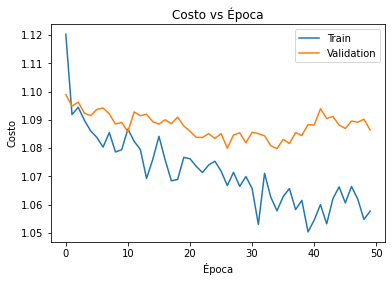

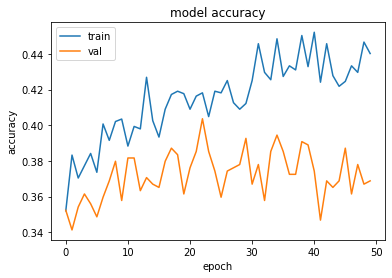

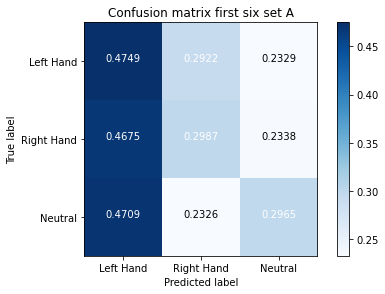

Channel 14
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.1044 - accuracy: 0.3736 - val_loss: 1.1014 - val_accuracy: 0.3688
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0927 - accuracy: 0.3856 - val_loss: 1.0982 - val_accuracy: 0.3725
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0927 - accuracy: 0.3911 - val_loss: 1.0930 - val_accuracy: 0.3725
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0863 - accuracy: 0.3897 - val_loss: 1.0912 - val_accuracy: 0.4000
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0835 - accuracy: 0.3971 - val_loss: 1.0881 - val_accuracy: 0.3982
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0814 - accuracy: 0.4049 - val_loss: 1.0854 - val_accuracy: 0.4037
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0807 - accuracy: 0.4072 - val_loss: 1.0880 - val_accuracy: 0.3872
Ep

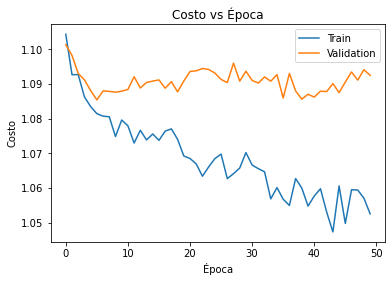

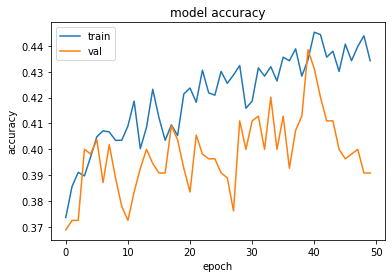

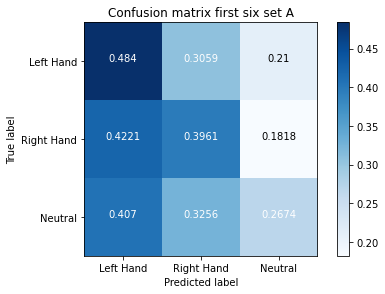

Channel 15
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.1145 - accuracy: 0.3534 - val_loss: 1.1049 - val_accuracy: 0.3670
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0940 - accuracy: 0.3847 - val_loss: 1.0966 - val_accuracy: 0.3890
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0960 - accuracy: 0.3773 - val_loss: 1.0967 - val_accuracy: 0.3706
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0896 - accuracy: 0.3801 - val_loss: 1.0945 - val_accuracy: 0.3633
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0865 - accuracy: 0.3819 - val_loss: 1.0930 - val_accuracy: 0.3761
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0858 - accuracy: 0.3847 - val_loss: 1.0926 - val_accuracy: 0.3761
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0865 - accuracy: 0.3980 - val_loss: 1.0944 - val_accuracy: 0.3725
Ep

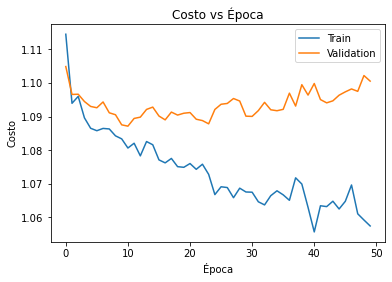

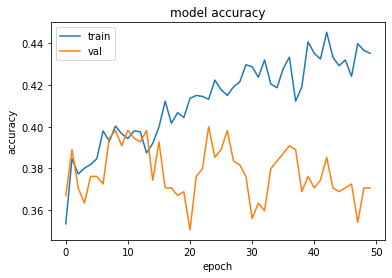

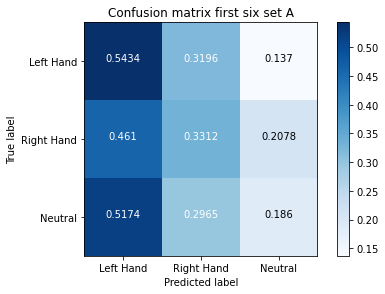

Channel 16
Epoch 1/50
68/68 [==============================] - 2s 22ms/step - loss: 1.1093 - accuracy: 0.3543 - val_loss: 1.0993 - val_accuracy: 0.3945
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0922 - accuracy: 0.3686 - val_loss: 1.0964 - val_accuracy: 0.3890
Epoch 3/50
68/68 [==============================] - 1s 17ms/step - loss: 1.0921 - accuracy: 0.3676 - val_loss: 1.0960 - val_accuracy: 0.3908
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0876 - accuracy: 0.3750 - val_loss: 1.0939 - val_accuracy: 0.3835
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0853 - accuracy: 0.3984 - val_loss: 1.0928 - val_accuracy: 0.3798
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0883 - accuracy: 0.3869 - val_loss: 1.0917 - val_accuracy: 0.3853
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0776 - accuracy: 0.3957 - val_loss: 1.0914 - val_accuracy: 0.4147
Ep

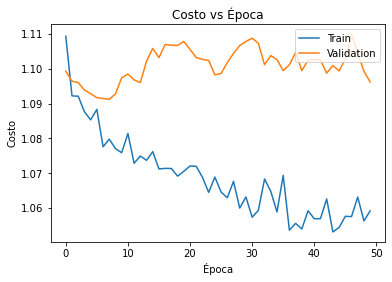

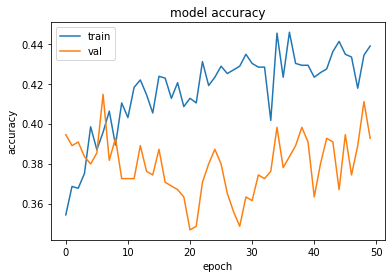

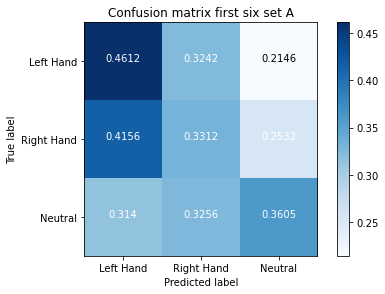

Channel 17
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.1011 - accuracy: 0.3658 - val_loss: 1.0848 - val_accuracy: 0.3963
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0911 - accuracy: 0.3727 - val_loss: 1.0753 - val_accuracy: 0.4055
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0871 - accuracy: 0.3801 - val_loss: 1.0822 - val_accuracy: 0.4055
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0818 - accuracy: 0.3856 - val_loss: 1.0808 - val_accuracy: 0.4037
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0786 - accuracy: 0.4040 - val_loss: 1.0791 - val_accuracy: 0.4073
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0777 - accuracy: 0.4067 - val_loss: 1.0831 - val_accuracy: 0.3835
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0763 - accuracy: 0.4067 - val_loss: 1.0841 - val_accuracy: 0.3651
Ep

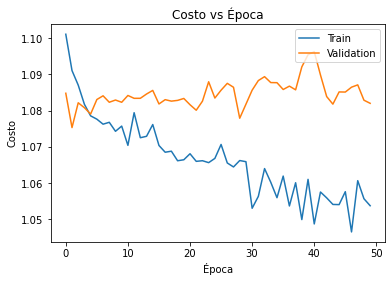

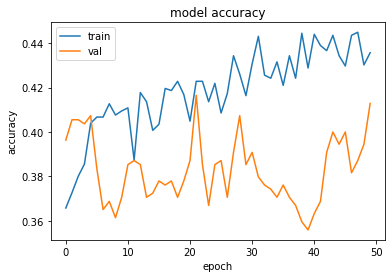

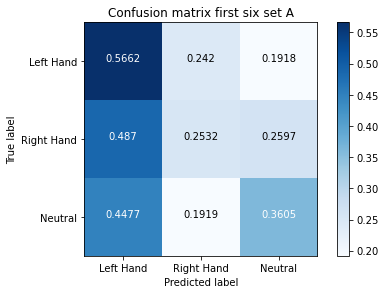

Channel 18
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.1119 - accuracy: 0.3603 - val_loss: 1.0964 - val_accuracy: 0.3541
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0961 - accuracy: 0.3667 - val_loss: 1.0961 - val_accuracy: 0.3523
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0812 - accuracy: 0.3975 - val_loss: 1.0986 - val_accuracy: 0.3413
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0787 - accuracy: 0.3938 - val_loss: 1.0938 - val_accuracy: 0.3688
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0797 - accuracy: 0.4030 - val_loss: 1.0941 - val_accuracy: 0.3615
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0793 - accuracy: 0.4113 - val_loss: 1.0936 - val_accuracy: 0.3541
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0796 - accuracy: 0.3975 - val_loss: 1.0926 - val_accuracy: 0.3413
Ep

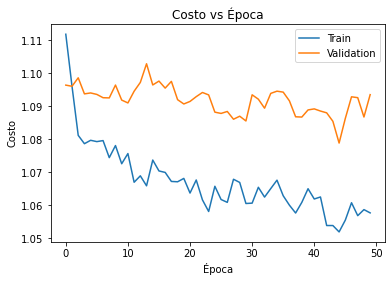

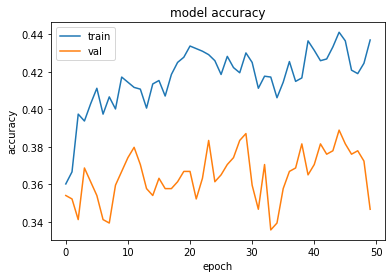

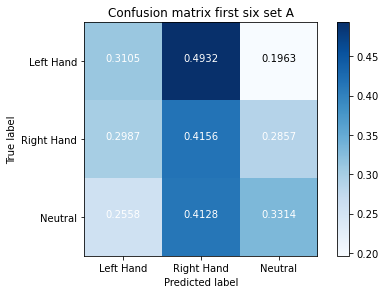

Channel 19
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.0954 - accuracy: 0.3791 - val_loss: 1.0975 - val_accuracy: 0.3780
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0871 - accuracy: 0.3971 - val_loss: 1.0955 - val_accuracy: 0.3651
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0782 - accuracy: 0.4058 - val_loss: 1.0939 - val_accuracy: 0.3780
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0823 - accuracy: 0.3952 - val_loss: 1.0958 - val_accuracy: 0.3670
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0752 - accuracy: 0.4062 - val_loss: 1.0899 - val_accuracy: 0.3633
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0789 - accuracy: 0.4012 - val_loss: 1.0894 - val_accuracy: 0.3615
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0777 - accuracy: 0.4030 - val_loss: 1.0909 - val_accuracy: 0.3761
Ep

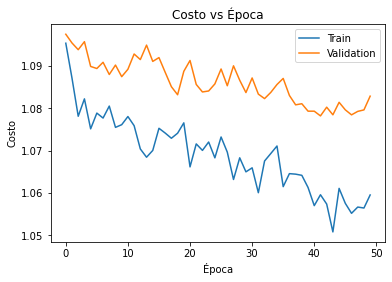

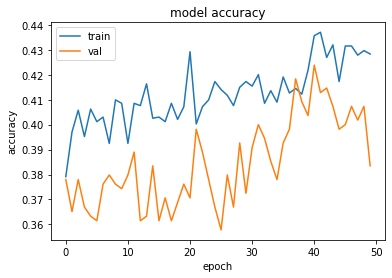

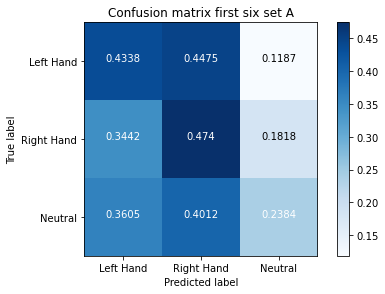

Channel 20
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.1109 - accuracy: 0.3552 - val_loss: 1.0978 - val_accuracy: 0.3817
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0989 - accuracy: 0.3612 - val_loss: 1.0955 - val_accuracy: 0.3927
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0923 - accuracy: 0.3837 - val_loss: 1.0970 - val_accuracy: 0.3945
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0856 - accuracy: 0.4003 - val_loss: 1.0989 - val_accuracy: 0.3706
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0896 - accuracy: 0.3782 - val_loss: 1.0979 - val_accuracy: 0.3835
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0855 - accuracy: 0.3957 - val_loss: 1.0950 - val_accuracy: 0.3798
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0870 - accuracy: 0.3773 - val_loss: 1.0934 - val_accuracy: 0.3908
Ep

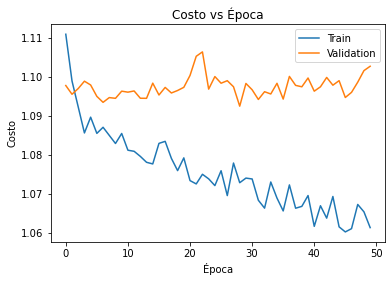

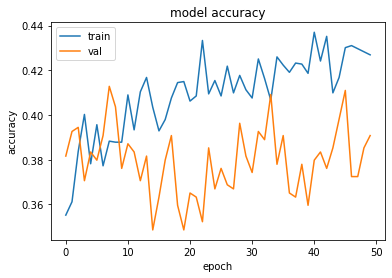

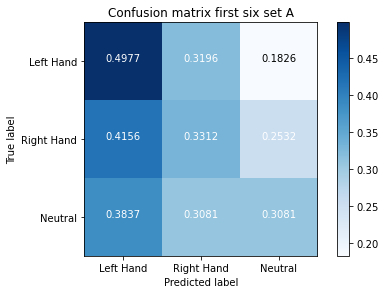

In [7]:
for i in range(6,21):
    comb = i
    print('Channel',i)
    testers(1e-3,comb,epochs=50,model=model)

Channel 1
Epoch 1/50
68/68 [==============================] - 5s 20ms/step - loss: 1.6253 - accuracy: 0.3474 - val_loss: 1.2534 - val_accuracy: 0.2844
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.4353 - accuracy: 0.3460 - val_loss: 1.1783 - val_accuracy: 0.3083
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.3187 - accuracy: 0.3529 - val_loss: 1.1621 - val_accuracy: 0.3450
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.2745 - accuracy: 0.3589 - val_loss: 1.1693 - val_accuracy: 0.3119
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.2418 - accuracy: 0.3493 - val_loss: 1.1400 - val_accuracy: 0.4000
Epoch 6/50
68/68 [==============================] - 1s 15ms/step - loss: 1.1877 - accuracy: 0.3635 - val_loss: 1.1452 - val_accuracy: 0.3431
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.1836 - accuracy: 0.3649 - val_loss: 1.1305 - val_accuracy: 0.3743
Epo

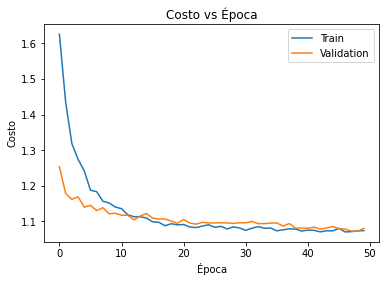

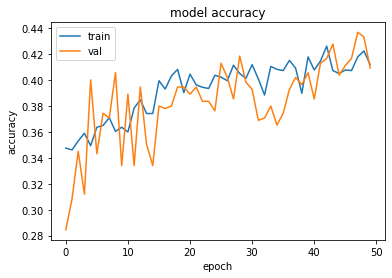

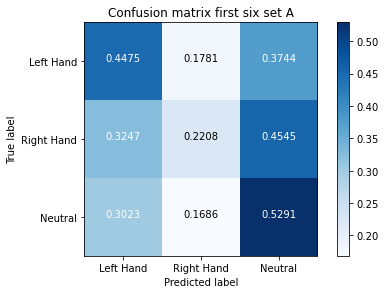

Channel 2
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.1062 - accuracy: 0.3736 - val_loss: 1.1062 - val_accuracy: 0.3578
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0976 - accuracy: 0.3658 - val_loss: 1.1039 - val_accuracy: 0.3780
Epoch 3/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0888 - accuracy: 0.3897 - val_loss: 1.1019 - val_accuracy: 0.3872
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0921 - accuracy: 0.3879 - val_loss: 1.1050 - val_accuracy: 0.3927
Epoch 5/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0906 - accuracy: 0.3796 - val_loss: 1.1057 - val_accuracy: 0.3835
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0904 - accuracy: 0.3653 - val_loss: 1.1063 - val_accuracy: 0.3486
Epoch 7/50
68/68 [==============================] - 1s 15ms/step - loss: 1.0987 - accuracy: 0.3626 - val_loss: 1.1043 - val_accuracy: 0.3339
Epo

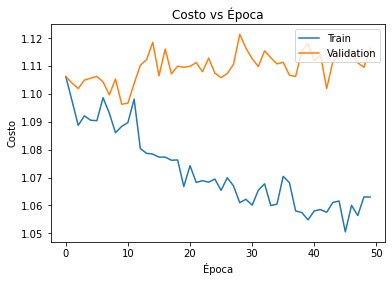

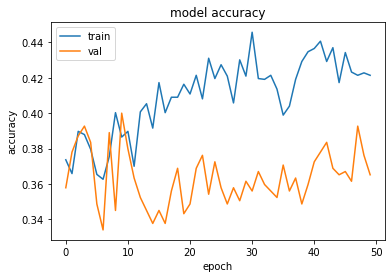

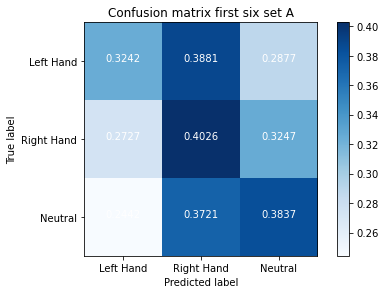

Channel 3
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.1024 - accuracy: 0.3699 - val_loss: 1.0900 - val_accuracy: 0.3725
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0919 - accuracy: 0.3667 - val_loss: 1.0898 - val_accuracy: 0.3761
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0870 - accuracy: 0.3718 - val_loss: 1.0867 - val_accuracy: 0.3743
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0845 - accuracy: 0.3925 - val_loss: 1.0875 - val_accuracy: 0.3835
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0832 - accuracy: 0.3892 - val_loss: 1.0910 - val_accuracy: 0.3725
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0803 - accuracy: 0.4095 - val_loss: 1.0895 - val_accuracy: 0.3560
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0767 - accuracy: 0.3957 - val_loss: 1.0891 - val_accuracy: 0.3633
Epo

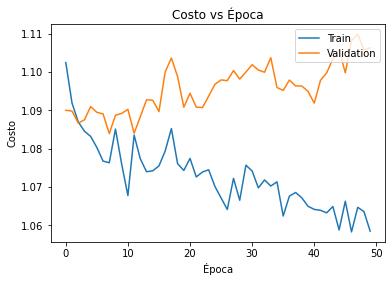

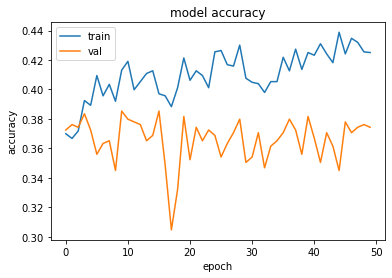

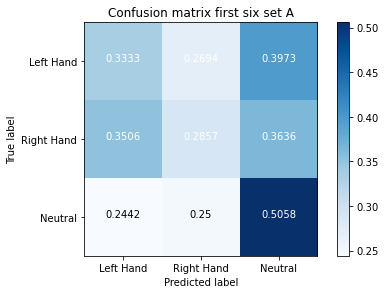

Channel 4
Epoch 1/50
68/68 [==============================] - 2s 18ms/step - loss: 1.0973 - accuracy: 0.3690 - val_loss: 1.0792 - val_accuracy: 0.3963
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0814 - accuracy: 0.3961 - val_loss: 1.0814 - val_accuracy: 0.3908
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0793 - accuracy: 0.3865 - val_loss: 1.0823 - val_accuracy: 0.3798
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0733 - accuracy: 0.4044 - val_loss: 1.0761 - val_accuracy: 0.4000
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0733 - accuracy: 0.4026 - val_loss: 1.0728 - val_accuracy: 0.4110
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0715 - accuracy: 0.3966 - val_loss: 1.0804 - val_accuracy: 0.3798
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0688 - accuracy: 0.4104 - val_loss: 1.0805 - val_accuracy: 0.3963
Epo

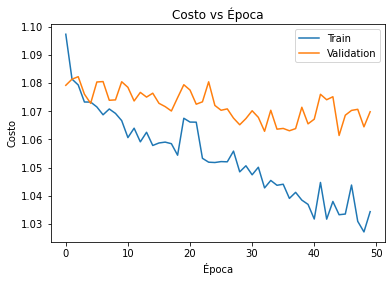

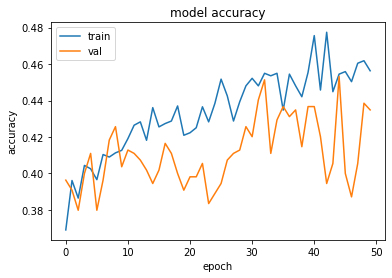

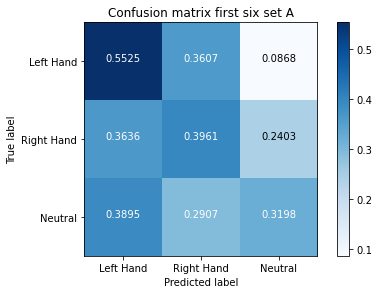

Channel 5
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.0482 - accuracy: 0.4407 - val_loss: 1.0854 - val_accuracy: 0.3761
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0408 - accuracy: 0.4472 - val_loss: 1.0839 - val_accuracy: 0.3927
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0488 - accuracy: 0.4449 - val_loss: 1.0820 - val_accuracy: 0.3872
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0486 - accuracy: 0.4531 - val_loss: 1.0847 - val_accuracy: 0.3982
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0547 - accuracy: 0.4329 - val_loss: 1.0880 - val_accuracy: 0.3890
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0467 - accuracy: 0.4467 - val_loss: 1.0806 - val_accuracy: 0.3963
Epoch 7/50
68/68 [==============================] - 1s 17ms/step - loss: 1.0522 - accuracy: 0.4444 - val_loss: 1.0849 - val_accuracy: 0.3780
Epo

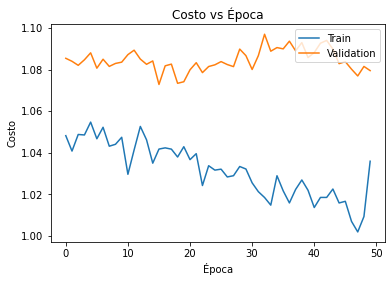

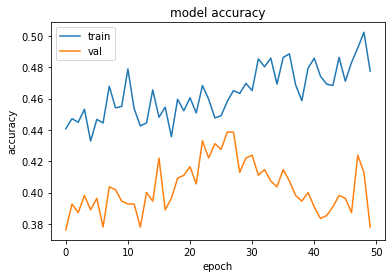

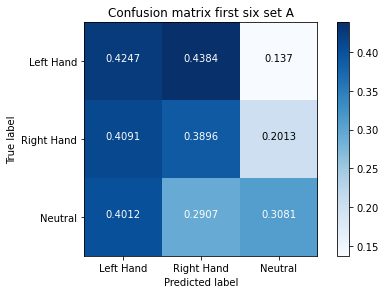

Channel 6
Epoch 1/50
68/68 [==============================] - 2s 19ms/step - loss: 1.1050 - accuracy: 0.3810 - val_loss: 1.1037 - val_accuracy: 0.3541
Epoch 2/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0877 - accuracy: 0.3814 - val_loss: 1.0987 - val_accuracy: 0.3321
Epoch 3/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0745 - accuracy: 0.4044 - val_loss: 1.0934 - val_accuracy: 0.3670
Epoch 4/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0793 - accuracy: 0.4085 - val_loss: 1.0900 - val_accuracy: 0.3706
Epoch 5/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0750 - accuracy: 0.4017 - val_loss: 1.0897 - val_accuracy: 0.3688
Epoch 6/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0702 - accuracy: 0.4113 - val_loss: 1.0882 - val_accuracy: 0.3872
Epoch 7/50
68/68 [==============================] - 1s 16ms/step - loss: 1.0698 - accuracy: 0.4145 - val_loss: 1.0877 - val_accuracy: 0.3927
Epo

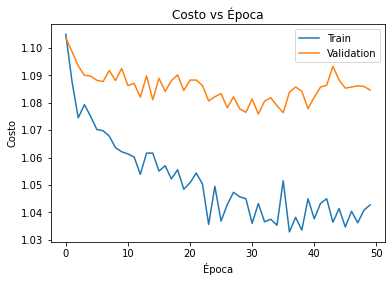

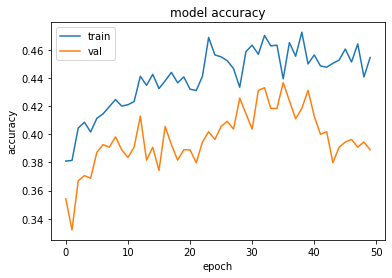

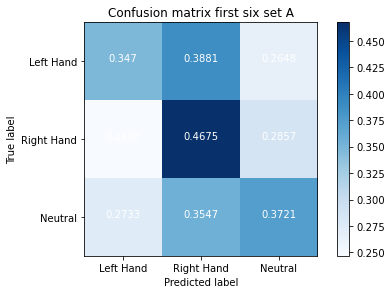

In [7]:
# comb = channel_combs['7']
for i in channel_combs['1']:
    comb = i
    print('Channel',i)
    testers(1e-3,comb,epochs=50,model=model)